In [1]:
import pandas as pd

# XGBoost data
df = pd.read_csv('greenland_nomastml_2023_12_15_13_35_10_XGBoost/Greenland_data_output_fold_4.csv')
# RF data
df_rf = pd.read_csv('greenland_nomastml_2023_12_13_14_06_39_RandomForest/Greenland_data_output_fold_4.csv')

# RF data, 5-fold on 20% subset
df_rf_subset = pd.read_csv('greenland_nomastml_2023_12_15_14_54_49/Greenland_data_output_fold_24.csv')



# Import the XGBoost and RF data 5fold on the full database

In [2]:
from ast import literal_eval
import numpy as np

yt1 = literal_eval(df.loc[0][1])
yt2 = literal_eval(df.loc[0][2])
yt3 = literal_eval(df.loc[0][3])
yt4 = literal_eval(df.loc[0][4])
yt5 = literal_eval(df.loc[0][5])
yt = np.concatenate([yt1, yt2, yt3, yt4, yt5])

yp1 = literal_eval(df.loc[1][1])
yp2 = literal_eval(df.loc[1][2])
yp3 = literal_eval(df.loc[1][3])
yp4 = literal_eval(df.loc[1][4])
yp5 = literal_eval(df.loc[1][5])
yp = np.concatenate([yp1, yp2, yp3, yp4, yp5])

In [3]:
yt1_rf = literal_eval(df_rf.loc[0][1])
yt2_rf = literal_eval(df_rf.loc[0][2])
yt3_rf = literal_eval(df_rf.loc[0][3])
yt4_rf = literal_eval(df_rf.loc[0][4])
yt5_rf = literal_eval(df_rf.loc[0][5])
yt_rf = np.concatenate([yt1_rf, yt2_rf, yt3_rf, yt4_rf, yt5_rf])

yp1_rf = literal_eval(df_rf.loc[1][1])
yp2_rf = literal_eval(df_rf.loc[1][2])
yp3_rf = literal_eval(df_rf.loc[1][3])
yp4_rf = literal_eval(df_rf.loc[1][4])
yp5_rf = literal_eval(df_rf.loc[1][5])
yp_rf = np.concatenate([yp1_rf, yp2_rf, yp3_rf, yp4_rf, yp5_rf])

e1 = literal_eval(df_rf.loc[6][1])
e2 = literal_eval(df_rf.loc[6][2])
e3 = literal_eval(df_rf.loc[6][3])
e4 = literal_eval(df_rf.loc[6][4])
e5 = literal_eval(df_rf.loc[6][5])
err_rf = np.concatenate([e1, e2, e3, e4, e5])

In [4]:
from mastml.plots import Scatter, Error
import os

forestci is an optional dependency. To install latest forestci compatabilty with scikit-learn>=0.24, run pip install git+git://github.com/scikit-learn-contrib/forest-confidence-interval.git


# Plot the uncalibrated RF error bars on all the data

In [7]:
from mastml.models import SklearnModel

model = SklearnModel('RandomForestRegressor')

res_rf = yt_rf - yp_rf

Error().plot_real_vs_predicted_error(savepath=os.getcwd(),
                                     model=model,
                                     data_type='test',
                                     model_errors=err_rf,
                                     residuals=res_rf,
                                     dataset_stdev=np.std(yt_rf),
                                    number_of_bins=15, # Can alter number of bins
                                    equal_sized_bins=False) # Can decide if regular binning procedure or constant points per bin

BIN WIDTH
0.24202607747838187


# Plot the raw and recalibrated RF error bars together (choose which recal params to use). Recalibration is done below using 5-fold CV on 20% subset of data

In [10]:
model = SklearnModel('RandomForestRegressor')

# Linear recal on 5-fold of 20% of data (25 splits)
err_rf_recal = 0.8173433332922072*err_rf + 7.049268040520348
#err_rf_recal = 5.63*err_rf 

# Quadratic recal on 5-fold of 20% of data (25 splits)
#err_rf_recal = -0.0024126558771530933*err_rf**2 + 1.0148930050945097*err_rf + 5.835408603026474

# Linear recal on full database
#err_rf_recal = 4.4574804209137575*err_rf +0.9066210639482649

# Manual recal based on inspecting constant bin plot w/ 100 bins
#err_rf_recal = err_rf*3.40 


Error().plot_real_vs_predicted_error_uncal_cal_overlay(savepath=os.getcwd(),
                                     model=model,
                                     data_type='test',
                                     model_errors=err_rf,
                                    model_errors_cal=err_rf_recal,
                                     residuals=res_rf,
                                     dataset_stdev=np.std(yt_rf),
                                    number_of_bins=15,
                                        equal_sized_bins=False)

BIN WIDTH
0.24202607747838187
BIN WIDTH
0.19781840090981861


# Get the uncal and recal error bars per bin and examine their CDF and z-score values

In [11]:
from mastml.error_analysis import ErrorUtils
import numpy as np

nbins = 15
digitized, err_values, rms_residual_values, num_values_per_bin, number_of_bins, ms_residual_values, var_sq_residual_values = ErrorUtils()._parse_error_data(model_errors=err_rf, 
                                                                                                                                                 residuals=res_rf, 
                                                                                                                                                 dataset_stdev=np.std(yt_rf), 
                                                                                                                                                 number_of_bins=nbins, 
                                                                                                                                                 equal_sized_bins=True)
data_dict = dict()
bins = np.unique(digitized)
counts = 0
for b, r, e in zip(digitized, res_rf, err_rf):
    if b not in data_dict.keys():
        data_dict[b] = {'res': list(), 'err': list(), 'z': list()}
    data_dict[b]['res'].append(r)
    data_dict[b]['err'].append(e)
    data_dict[b]['z'].append(r/e)
    if b < 2:
        counts += 1

bin_z_means = list()
bin_z_stds = list()
res_means = list()
err_means = list()
#for k, v in sorted(data_dict.items()): #HERE changed to sorted
for k in data_dict.keys():
    print(k)
    v = data_dict[k]
    bin_z_means.append(np.mean(v['z']))
    res_means.append(np.mean(v['res']))
    err_means.append(np.mean(v['err']))
    bin_z_stds.append(np.std(v['z']))

BIN WIDTH
0.0017570499225767128
12
9
15
14
10
13
11
4
8
7
6
5
3
1
2
16


In [13]:
'''
# Try recalibrating errors on a per-bin basis
recal_params_bin_list = list()
err_recal_perbin_list = list()
for k, v in sorted(data_dict.items()): # HERE changed to sorted
    err_recal_perbin, recal_dict_perbin = ErrorUtils()._recalibrate_errors(model_errors=v['err'], residuals=v['res'], power=1)
    print(k, recal_dict_perbin)
    recal_params_bin_list.append(recal_dict_perbin)
    err_recal_perbin_list.append(err_recal_perbin)
'''

"\n# Try recalibrating errors on a per-bin basis\nrecal_params_bin_list = list()\nerr_recal_perbin_list = list()\nfor k, v in sorted(data_dict.items()): # HERE changed to sorted\n    err_recal_perbin, recal_dict_perbin = ErrorUtils()._recalibrate_errors(model_errors=v['err'], residuals=v['res'], power=1)\n    print(k, recal_dict_perbin)\n    recal_params_bin_list.append(recal_dict_perbin)\n    err_recal_perbin_list.append(err_recal_perbin)\n"

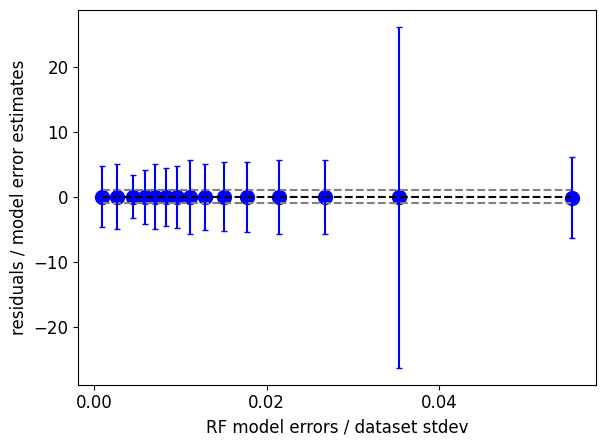

In [14]:
from matplotlib import pyplot as plt

plt.clf()
plt.scatter(err_values, bin_z_means[0:nbins], color='blue', s=100)
plt.plot([min(err_values), max(err_values)], [0, 0], color='black', linestyle='--')
plt.plot([min(err_values), max(err_values)], [1, 1], color='gray', linestyle='--')
plt.plot([min(err_values), max(err_values)], [-1, -1], color='gray', linestyle='--')

plt.errorbar(x=err_values, y=bin_z_means[0:nbins], yerr=bin_z_stds[0:nbins], ecolor='blue', elinewidth=1.5, capsize=2, linewidth=0)
plt.xlabel('RF model errors / dataset stdev', fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('residuals / model error estimates', fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('Zscore_vs_Err_eachbin_uncal.png', dpi=300, bbox_inches='tight')


In [ ]:
'''
12 {'a': 2.9896003875742956, 'b': 6.926783713806093}
3.869583717012148
9 {'a': 4.95839852040954, 'b': 0.00380333235822764}
5.434403978557816
15 {'a': 1.8157918064860838, 'b': 22.822519648568207}
4.87440768534887
14 {'a': 3.207152387802969, 'b': 7.197142214480411}
4.041505208173825
10 {'a': 4.9663322389893345, 'b': 0.0037819479987099384}
4.581232765806825
13 {'a': 3.961102470906577, 'b': 2.508798904440548}
4.190729798324634
11 {'a': 5.466950803537122, 'b': -2.287868016542865}
3.1717443046161744
4 {'a': 4.533083726258043, 'b': 1.2156338100545159}
3.733535704629854
8 {'a': 3.57295687635243, 'b': 3.0019071647299658}
3.616927119636676
7 {'a': 3.245391037863654, 'b': 3.4780657477849566}
3.47323410862429
6 {'a': 5.92667321699445, 'b': -0.8137161018762693}
3.3521018366218454
5 {'a': 4.631516872863045, 'b': 1.2357635109034386}
2.9048117865533536
3 {'a': 5.95476542200308, 'b': -0.16553097147550355}
1.7864729696784498
1 {'a': 5.6042702714912345, 'b': 0.7133486861070276}
2.51376818504784
2 {'a': 5.396124021156214, 'b': 0.40014629076808383}
7.891985159924561
16 {'a': 0.9914772987365721, 'b': 4.4744253158569354e-05}

'''

In [15]:
from mastml.error_analysis import ErrorUtils
import numpy as np


digitized_recal, err_values_recal, rms_residual_values, num_values_per_bin, number_of_bins, ms_residual_values, var_sq_residual_values = ErrorUtils()._parse_error_data(model_errors=err_rf_recal, 
                                                                                                                                                 residuals=res_rf, 
                                                                                                                                                 dataset_stdev=np.std(yt_rf), 
                                                                                                                                                 number_of_bins=nbins, 
                                                                                                                                                 equal_sized_bins=True)
data_dict_recal = dict()
bins = np.unique(digitized_recal)

err_recal_perbin_all = list()

for b, r, e, eu in zip(digitized_recal, res_rf, err_rf_recal, err_rf):
    if b not in data_dict_recal.keys():
        data_dict_recal[b] = {'res': list(), 'err': list(), 'z': list(), 'err_perbin': list(), 'z_perbin': list()}
    data_dict_recal[b]['res'].append(r)
    data_dict_recal[b]['err'].append(e)
    data_dict_recal[b]['z'].append(r/e)
    # per bin recal
    if b == 12:
        e2 = 2.9896003875742956*eu+6.926783713806093
    elif b == 9:
        e2 = 4.95839852040954*eu+0.00380333235822764
    elif b == 15:
        e2 = 1.8157918064860838*eu+22.822519648568207
    elif b == 14:
        e2 = 3.207152387802969*eu+7.197142214480411
    elif b == 10:
        e2 = 4.9663322389893345*eu+0.0037819479987099384
    elif b == 13:
        e2 = 3.961102470906577*eu+2.508798904440548
    elif b == 11:
        e2 = 5.466950803537122*eu-2.287868016542865
    elif b == 4:
        e2 = 4.533083726258043*eu+1.2156338100545159
    elif b == 8:
        e2 = 3.57295687635243*eu+3.0019071647299658
    elif b == 7:
        e2 = 3.245391037863654*eu+3.4780657477849566
    elif b == 6:
        e2 = 5.92667321699445*eu-0.8137161018762693
    elif b == 5:
        e2 = 4.631516872863045*eu+1.2357635109034386
    elif b == 3:
        e2 = 5.95476542200308*eu-0.16553097147550355
    elif b == 1:
        e2 = 5.6042702714912345*eu+0.40014629076808383
    elif b == 2:
        e2 = 5.396124021156214*eu+0.7133486861070276
    elif b == 16:
        e2 = 0.9914772987365721*eu+4.4744253158569354e-05
    data_dict_recal[b]['err_perbin'].append(e2)
    data_dict_recal[b]['z_perbin'].append(r/e2)
    
    err_recal_perbin_all.append(e2)
    
bin_z_means_recal = list()
bin_z_stds_recal = list()
#for k, v in data_dict_recal.items(): # HERE made sorted
for k in data_dict_recal.keys():
    v = data_dict_recal[k]
    bin_z_means_recal.append(np.mean(v['z']))
    bin_z_stds_recal.append(np.std(v['z']))
    
bin_z_means_recal_perbin = list()
bin_z_stds_recal_perbin = list()
err_values_recal_perbin = list()
#for k, v in data_dict_recal.items(): # HERE made sorted
for k in data_dict_recal.keys():
    v = data_dict_recal[k]
    err_values_recal_perbin.append(np.mean(v['err_perbin']/np.std(yt_rf)))
    bin_z_means_recal_perbin.append(np.mean(v['z_perbin']))
    bin_z_stds_recal_perbin.append(np.std(v['z_perbin']))


BIN WIDTH
0.001436113040479664


In [16]:
# Process the per-bin calibrated error data
digitized_recal_perbin, err_values_recal_perbin, rms_residual_values, num_values_per_bin, number_of_bins, ms_residual_values, var_sq_residual_values = ErrorUtils()._parse_error_data(model_errors=err_recal_perbin_all, 
                                                                                                                                                 residuals=res_rf, 
                                                                                                                                                 dataset_stdev=np.std(yt_rf), 
                                                                                                                                                 number_of_bins=nbins, 
                                                                                                                                                 equal_sized_bins=True)

BIN WIDTH
0.010396914886064201


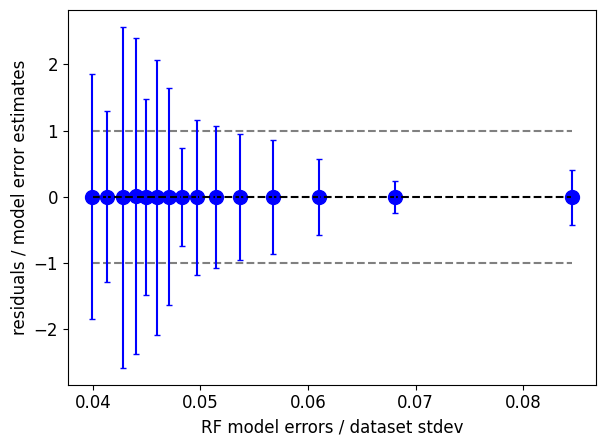

In [17]:
plt.clf()
plt.scatter(err_values_recal, bin_z_means_recal[0:nbins], color='blue', s=100)
plt.plot([min(err_values_recal), max(err_values_recal)], [0, 0], color='black', linestyle='--')
plt.plot([min(err_values_recal), max(err_values_recal)], [1, 1], color='gray', linestyle='--')
plt.plot([min(err_values_recal), max(err_values_recal)], [-1, -1], color='gray', linestyle='--')

plt.errorbar(x=err_values_recal, y=bin_z_means_recal[0:nbins], yerr=bin_z_stds_recal[0:nbins], ecolor='blue', elinewidth=1.5, capsize=2, linewidth=0)
plt.xlabel('RF model errors / dataset stdev', fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('residuals / model error estimates', fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('Zscore_vs_Err_eachbin_cal.png', dpi=300, bbox_inches='tight')


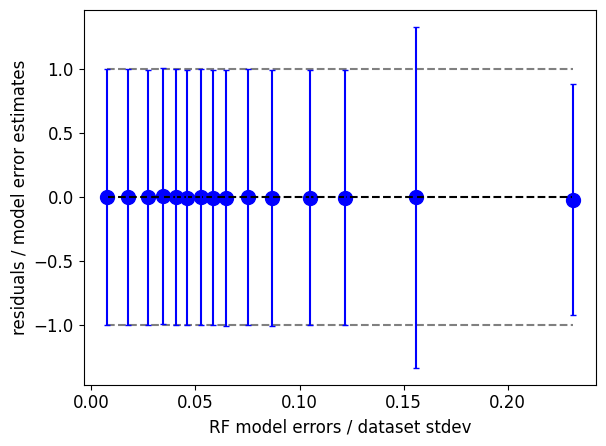

In [18]:
# Use per-bin recal
plt.clf()
plt.scatter(err_values_recal_perbin[0:nbins], bin_z_means_recal_perbin[0:nbins], color='blue', s=100)
plt.plot([min(err_values_recal_perbin[0:nbins]), max(err_values_recal_perbin[0:nbins])], [0, 0], color='black', linestyle='--')
plt.plot([min(err_values_recal_perbin[0:nbins]), max(err_values_recal_perbin[0:nbins])], [1, 1], color='gray', linestyle='--')
plt.plot([min(err_values_recal_perbin[0:nbins]), max(err_values_recal_perbin[0:nbins])], [-1, -1], color='gray', linestyle='--')

plt.errorbar(x=err_values_recal_perbin[0:nbins], y=bin_z_means_recal_perbin[0:nbins], yerr=bin_z_stds_recal_perbin[0:nbins], ecolor='blue', elinewidth=1.5, capsize=2, linewidth=0)
plt.xlabel('RF model errors / dataset stdev', fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('residuals / model error estimates', fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('Zscore_vs_Err_eachbin_cal_perbin.png', dpi=300, bbox_inches='tight')

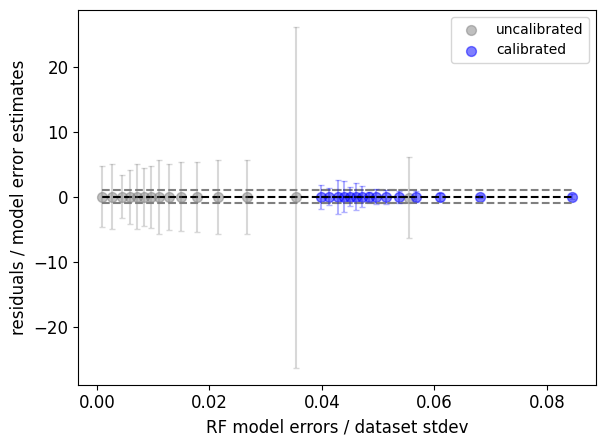

In [19]:
# Plot both uncal and recal together


plt.clf()

# Uncal values
plt.scatter(err_values, bin_z_means[0:nbins], color='gray', s=50, label='uncalibrated', alpha=0.5)
plt.plot([min(err_values), max(err_values)], [0, 0], color='black', linestyle='--')
plt.plot([min(err_values), max(err_values)], [1, 1], color='gray', linestyle='--')
plt.plot([min(err_values), max(err_values)], [-1, -1], color='gray', linestyle='--')

plt.errorbar(x=err_values, y=bin_z_means[0:nbins], yerr=bin_z_stds[0:nbins], ecolor='gray', elinewidth=1.5, capsize=2, linewidth=0, alpha=0.3)


# Recal values
plt.scatter(err_values_recal, bin_z_means_recal[0:nbins], color='blue', s=50, label='calibrated', alpha=0.5)
plt.plot([min(err_values_recal), max(err_values_recal)], [0, 0], color='black', linestyle='--')
plt.plot([min(err_values_recal), max(err_values_recal)], [1, 1], color='gray', linestyle='--')
plt.plot([min(err_values_recal), max(err_values_recal)], [-1, -1], color='gray', linestyle='--')

plt.errorbar(x=err_values_recal, y=bin_z_means_recal[0:nbins], yerr=bin_z_stds_recal[0:nbins], ecolor='blue', elinewidth=1.5, capsize=2, linewidth=0, alpha=0.3)
plt.xlabel('RF model errors / dataset stdev', fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('residuals / model error estimates', fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='best', fontsize=10)

plt.savefig('Zscore_vs_Err_eachbin_uncal_cal_together.png', dpi=300, bbox_inches='tight')

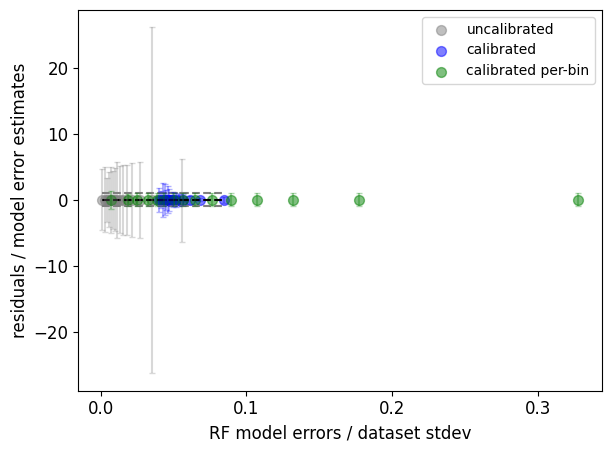

In [276]:
# Plot both uncal and recal and recal per bin together

plt.clf()

# Uncal values
plt.scatter(err_values, bin_z_means[0:nbins], color='gray', s=50, label='uncalibrated', alpha=0.5)
plt.plot([min(err_values), max(err_values)], [0, 0], color='black', linestyle='--')
plt.plot([min(err_values), max(err_values)], [1, 1], color='gray', linestyle='--')
plt.plot([min(err_values), max(err_values)], [-1, -1], color='gray', linestyle='--')

plt.errorbar(x=err_values, y=bin_z_means[0:nbins], yerr=bin_z_stds[0:nbins], ecolor='gray', elinewidth=1.5, capsize=2, linewidth=0, alpha=0.3)

# Recal values
plt.scatter(err_values_recal, bin_z_means_recal[0:nbins], color='blue', s=50, label='calibrated', alpha=0.5)
plt.plot([min(err_values_recal), max(err_values_recal)], [0, 0], color='black', linestyle='--')
plt.plot([min(err_values_recal), max(err_values_recal)], [1, 1], color='gray', linestyle='--')
plt.plot([min(err_values_recal), max(err_values_recal)], [-1, -1], color='gray', linestyle='--')

plt.errorbar(x=err_values_recal, y=bin_z_means_recal[0:nbins], yerr=bin_z_stds_recal[0:nbins], ecolor='blue', elinewidth=1.5, capsize=2, linewidth=0, alpha=0.3)

# Recal w/ recal per bin values
plt.scatter(err_values_recal_perbin[0:nbins], bin_z_means_recal_perbin[0:nbins], color='green', s=50, label='calibrated per-bin', alpha=0.5)
#plt.plot([min(err_values_recal_perbin), max(err_values_recal_perbin)], [0, 0], color='black', linestyle='--')
#plt.plot([min(err_values_recal_perbin), max(err_values_recal_perbin)], [1, 1], color='gray', linestyle='--')
#plt.plot([min(err_values_recal_perbin), max(err_values_recal_perbin)], [-1, -1], color='gray', linestyle='--')

plt.errorbar(x=err_values_recal_perbin[0:nbins], y=bin_z_means_recal_perbin[0:nbins], yerr=bin_z_stds_recal_perbin[0:nbins], ecolor='green', elinewidth=1.5, capsize=2, linewidth=0, alpha=0.3)
plt.xlabel('RF model errors / dataset stdev', fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('residuals / model error estimates', fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='best', fontsize=10)

#plt.xlim(0, 0.3)

plt.savefig('Zscore_vs_Err_eachbin_uncal_cal_together_perbin.png', dpi=300, bbox_inches='tight')

# In addition to Z-score per bin, want to examine error in error (via CDF miscalibration) per bin

In [ ]:
#!pip install madml --upgrade

In [20]:
from madml.plots import cdf

In [21]:
areas = dict()
for b in data_dict.keys():
    y, y_pred, areaparity, areacdf = cdf(data_dict[b]['z'], save=None, subsave='_uncal_bin'+str(b))
    areas[b] = areaparity
#cdf(z_values_cal, savepath, subsave='_calibrated')
areas

{12: 0.17409915919871718,
 9: 0.18203413810536584,
 15: 0.07982501858981933,
 14: 0.1464556816511534,
 10: 0.18098755813601045,
 13: 0.16757679209796464,
 11: 0.1764373887995997,
 4: 0.18812286202570352,
 8: 0.18367353800346617,
 7: 0.1845164746771411,
 6: 0.18844151483340696,
 5: 0.18816108454554853,
 3: 0.18631751586029469,
 1: 0.20290251053104158,
 2: 0.19001037770903004,
 16: nan}

In [22]:
areas_recal = dict()
for b in data_dict_recal.keys():
    y, y_pred, areaparity, areacdf = cdf(data_dict_recal[b]['z'], save=None, subsave='_cal_bin'+str(b))
    areas_recal[b] = areaparity

In [23]:
areas = dict(sorted(areas.items()))
areas = np.array(list(areas.values()))
#areas = areas[~np.isnan(areas)]
areas

array([0.20290251, 0.19001038, 0.18631752, 0.18812286, 0.18816108,
       0.18844151, 0.18451647, 0.18367354, 0.18203414, 0.18098756,
       0.17643739, 0.17409916, 0.16757679, 0.14645568, 0.07982502,
              nan])

In [24]:
areas_recal = dict(sorted(areas_recal.items()))
areas_recal = np.array(list(areas_recal.values()))
#areas = areas[~np.isnan(areas)]
areas_recal

array([0.20945562, 0.13933444, 0.09755128, 0.06572914, 0.03966053,
       0.02209144, 0.01221808, 0.0196008 , 0.03385   , 0.05077542,
       0.06354947, 0.0813559 , 0.09396163, 0.09363194, 0.05820546,
              nan])

In [25]:
areas_recal_perbin = dict()
for b in data_dict_recal.keys():
    y, y_pred, areaparity, areacdf = cdf(data_dict_recal[b]['z_perbin'], save=None, subsave='_cal_bin'+str(b))
    areas_recal_perbin[b] = areaparity

In [26]:
areas_recal_perbin = dict(sorted(areas_recal_perbin.items()))
areas_recal_perbin = np.array(list(areas_recal_perbin.values()))
#areas = areas[~np.isnan(areas)]
areas_recal_perbin

array([0.06484724, 0.03869184, 0.02455413, 0.02352762, 0.01973626,
       0.01561848, 0.01808563, 0.01613122, 0.01922748, 0.01869966,
       0.01841334, 0.01617251, 0.01340277, 0.02311173, 0.05276402,
              nan])

In [ ]:
'''
import json
import os

for f in os.listdir('each_bin'):
    if '.json' in f and 'cdf_parity' in f:
        with open('each_bin/'+f, 'r') as f1:
            d = json.load(f1)
            print(f1)
            print(d['Area'])
'''

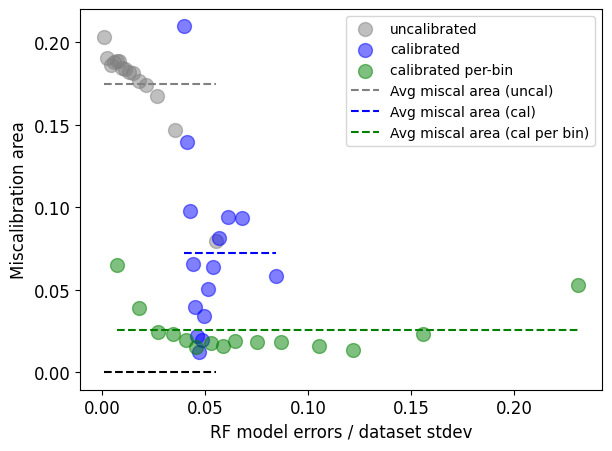

In [27]:
plt.clf()
plt.scatter(err_values, areas[0:nbins], color='blue', s=100)
plt.plot([min(err_values), max(err_values)], [0, 0], color='black', linestyle='--')
#plt.plot([min(err_values_recal), max(err_values_recal)], [1, 1], color='gray', linestyle='--')
#plt.plot([min(err_values_recal), max(err_values_recal)], [-1, -1], color='gray', linestyle='--')

#plt.errorbar(x=err_values_recal, y=bin_z_means_recal, yerr=bin_z_stds_recal, ecolor='blue', elinewidth=1.5, capsize=2, linewidth=0)
plt.xlabel('RF model errors / dataset stdev', fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Miscalibration area', fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('MiscalArea_vs_Err_eachbin_uncal.png', dpi=300, bbox_inches='tight')

plt.clf()
plt.scatter(err_values_recal, areas_recal[0:nbins], color='blue', s=100)
plt.plot([min(err_values_recal), max(err_values_recal)], [0, 0], color='black', linestyle='--')
#plt.plot([min(err_values_recal), max(err_values_recal)], [1, 1], color='gray', linestyle='--')
#plt.plot([min(err_values_recal), max(err_values_recal)], [-1, -1], color='gray', linestyle='--')

#plt.errorbar(x=err_values_recal, y=bin_z_means_recal, yerr=bin_z_stds_recal, ecolor='blue', elinewidth=1.5, capsize=2, linewidth=0)
plt.xlabel('RF model errors / dataset stdev', fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Miscalibration area', fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('MiscalArea_vs_Err_eachbin_cal.png', dpi=300, bbox_inches='tight')


plt.clf()
plt.scatter(err_values, areas[0:nbins], color='gray', s=100, alpha=0.5, label='uncalibrated')
plt.scatter(err_values_recal, areas_recal[0:nbins], color='blue', s=100, alpha=0.5, label='calibrated')
plt.plot([min(err_values), max(err_values)], [0, 0], color='black', linestyle='--')
#plt.plot([min(err_values_recal), max(err_values_recal)], [1, 1], color='gray', linestyle='--')
#plt.plot([min(err_values_recal), max(err_values_recal)], [-1, -1], color='gray', linestyle='--')
areas = areas[~np.isnan(areas)]
avg_miscal = np.mean(areas[0:nbins])
plt.plot([min(err_values), max(err_values)], [avg_miscal, avg_miscal], color='grey', linestyle='--', label='Avg miscal area (uncal)')
areas_recal = areas_recal[~np.isnan(areas_recal)]
avg_miscal_recal = np.mean(areas_recal[0:nbins])
plt.plot([min(err_values_recal), max(err_values_recal)], [avg_miscal_recal, avg_miscal_recal], color='blue', linestyle='--', label='Avg miscal area (cal)')

#plt.errorbar(x=err_values_recal, y=bin_z_means_recal, yerr=bin_z_stds_recal, ecolor='blue', elinewidth=1.5, capsize=2, linewidth=0)
plt.xlabel('RF model errors / dataset stdev', fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Miscalibration area', fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='best', fontsize=10)

plt.savefig('MiscalArea_vs_Err_eachbin_uncal_cal_together.png', dpi=300, bbox_inches='tight')


plt.clf()
plt.scatter(err_values, areas[0:nbins], color='gray', s=100, alpha=0.5, label='uncalibrated')
plt.scatter(err_values_recal, areas_recal[0:nbins], color='blue', s=100, alpha=0.5, label='calibrated')
plt.scatter(err_values_recal_perbin[0:nbins], areas_recal_perbin[0:nbins], color='green', s=100, alpha=0.5, label='calibrated per-bin')
plt.plot([min(err_values), max(err_values)], [0, 0], color='black', linestyle='--')
#plt.plot([min(err_values_recal), max(err_values_recal)], [1, 1], color='gray', linestyle='--')
#plt.plot([min(err_values_recal), max(err_values_recal)], [-1, -1], color='gray', linestyle='--')
areas = areas[~np.isnan(areas)]
avg_miscal = np.mean(areas[0:nbins])
plt.plot([min(err_values), max(err_values)], [avg_miscal, avg_miscal], color='grey', linestyle='--', label='Avg miscal area (uncal)')
areas_recal = areas_recal[~np.isnan(areas_recal)]
avg_miscal_recal = np.mean(areas_recal[0:nbins])
plt.plot([min(err_values_recal), max(err_values_recal)], [avg_miscal_recal, avg_miscal_recal], color='blue', linestyle='--', label='Avg miscal area (cal)')

areas_recal_perbin = areas_recal_perbin[~np.isnan(areas_recal_perbin)]
avg_miscal_recal_perbin = np.mean(areas_recal_perbin[0:nbins])
plt.plot([min(err_values_recal_perbin[0:nbins]), max(err_values_recal_perbin[0:nbins])], [avg_miscal_recal_perbin, avg_miscal_recal_perbin], color='green', linestyle='--', label='Avg miscal area (cal per bin)')


#plt.errorbar(x=err_values_recal, y=bin_z_means_recal, yerr=bin_z_stds_recal, ecolor='blue', elinewidth=1.5, capsize=2, linewidth=0)
plt.xlabel('RF model errors / dataset stdev', fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Miscalibration area', fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='best', fontsize=10)

plt.savefig('MiscalArea_vs_Err_eachbin_uncal_cal_together_perbin.png', dpi=300, bbox_inches='tight')


In [28]:
'''
e_recal_per_bin = list()
e_uncal_per_bin = list()
e_per_bin = list()
res_per_bin = list()
for b in data_dict_recal.keys():
    e_recal_per_bin.append(data_dict_recal[b]['err_perbin'])
    e_per_bin.append(data_dict_recal[b]['err'])
    res_per_bin.append(data_dict_recal[b]['res'])

for b in data_dict.keys():
    e_uncal_per_bin.append(data_dict[b]['err'])
    
e_recal_per_bin_arr = np.concatenate(np.array([i for i in e_recal_per_bin]))
e_uncal_per_bin_arr = np.concatenate(np.array([i for i in e_uncal_per_bin]))
e_per_bin_arr = np.concatenate(np.array([i for i in e_per_bin]))
res_per_bin_arr = np.concatenate(np.array([i for i in res_per_bin]))

print(e_recal_per_bin_arr.shape)
'''
Error().plot_real_vs_predicted_error_uncal_cal_overlay(savepath=os.getcwd(),
                                     model=model,
                                     data_type='test',
                                     model_errors=err_rf, #e_per_bin_arr, #err_rf,
                                    model_errors_cal=err_recal_perbin_all, #e_recal_per_bin_arr,
                                     residuals=res_rf,#res_rf,
                                     dataset_stdev=np.std(yt_rf),
                                    number_of_bins=15,
                                        equal_sized_bins=True)

BIN WIDTH
0.0017570499225767128
BIN WIDTH
0.010396914886064201


In [201]:
e_per_bin_arr

array([2.32057406e+01, 2.21750583e+01, 2.25277366e+01, ...,
       2.66598493e+00, 2.76219274e+00, 3.67649557e+03])

In [202]:
e_uncal_per_bin_arr

array([4.12180117e+00, 3.93873148e+00, 4.00137418e+00, ...,
       4.73531959e-01, 4.90620379e-01, 6.53018752e+02])

In [205]:
count = 0
for i, j in zip(err_rf, e_uncal_per_bin_arr):
    if count < 50:
        print(i, j)
        count +=1

4.121801174551697 4.121801174551697
2.5151170352692565 3.9387314841152703
14.982617102559805 4.00137418231787
9.977322216199527 4.413736686008231
39.82315730988876 4.052430703019513
9.43662608593972 4.238077561275549
15.940796118115335 3.7891604386099544
9.043448726382834 4.301307785419267
45.089487590172105 4.5485347445707855
45.089487590172105 4.1422249863871645
45.990076153371696 4.115729451243585
37.89282258541557 3.9546216012492286
39.004923450196024 3.978262279308246
24.441612207778675 4.251705145892933
46.274405425042175 4.5619812504856805
43.45398955260975 4.200360883532103
68.59745705021227 3.9769177219549507
75.23434350829969 3.8638063142313617
2.7933433332698843 4.37598359871521
8.96878757783191 4.329877719254062
14.9679033432809 4.366271181120123
19.290021675846663 3.98808310263433
10.897762054238349 4.238735903416051
12.296730541392577 4.255066928051983
9.368784446581646 4.621112603192228
5.785715589562391 3.829414118953685
17.28107888502086 4.09387560885697
40.60379366006

In [129]:
areas_recal

{1: 0.024980274025607773,
 2: 0.03815391029717648,
 3: 0.056813693027479906,
 4: 0.07370780716453273,
 5: 0.1253261200769462,
 6: 0.07643328925743867,
 15: 0.38587518983177704,
 9: nan,
 8: 0.26061628928803976,
 7: 0.3032246808477768,
 10: nan}

# Plot the residual histogram of the XGBoost and RF runs 

21.095574642803644 10.725475668475143
-0.04135220535152919 -0.017666276079070554
30.871077983259116 20.695615925718823
-338.288208046875 -315.1673142160049
960.557067863281 647.4532736482265


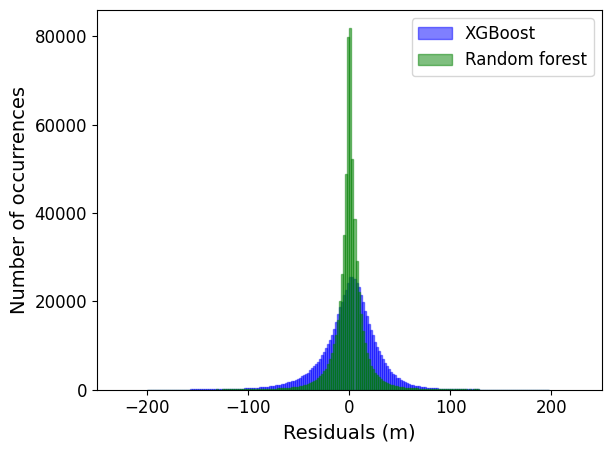

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

res_xgb = yt - yp
res_rf = yt_rf - yp_rf

#bins = 200
bins = np.arange(-200, 200, 2)

plt.hist(res_xgb, bins=bins, color='blue', edgecolor='blue', alpha=0.5, label='XGBoost')
plt.hist(res_rf, bins=bins, color='green', edgecolor='green', alpha=0.5, label='Random forest')

plt.xlim(-250, 250)
plt.xlabel('Residuals (m)', fontsize=14)
plt.ylabel('Number of occurrences', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.savefig('residual_histogram.png', dpi=300, bbox_inches='tight')

print(mean_absolute_error(yt, yp), mean_absolute_error(yt_rf, yp_rf))
print(np.mean(res_xgb), np.mean(res_rf))
print(np.std(res_xgb), np.std(res_rf))
print(min(res_xgb), min(res_rf))
print(max(res_xgb), max(res_rf))

# Make the parity plots of the XGBoost and RF runs

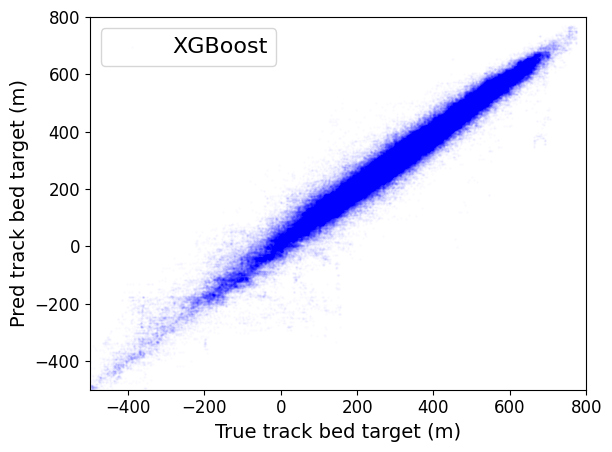

In [30]:
plt.scatter(yt_rf, yp_rf, s=1, alpha=0.01, color='green', label='Random Forest')
plt.xlabel('True track bed target (m)', fontsize=14)
plt.ylabel('Pred track bed target (m)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-500, 800)
plt.ylim(-500, 800)
plt.legend(loc='best')
plt.savefig('parity_small_RF.png', dpi=400, bbox_inches='tight')

plt.clf()
plt.scatter(yt, yp, s=1, alpha=0.01, color='blue', label='XGBoost')
plt.xlabel('True track bed target (m)', fontsize=14)
plt.ylabel('Pred track bed target (m)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-500, 800)
plt.ylim(-500, 800)
plt.legend(loc='best')
plt.savefig('parity_small_XGB.png', dpi=400, bbox_inches='tight')

# Examine the error bars and recalibrate them

In [31]:
df_rf_err = pd.read_csv('greenland_nomastml_2023_12_15_14_54_49/Greenland_data_output_fold_24.csv')

err_list = list()
res_list = list()
true_list = list()
for i in range(df_rf_err.loc[6].shape[0]):
    if i > 0:
        e = literal_eval(df_rf_err.loc[6][i])
        err_list.append(e)
        t = literal_eval(df_rf_err.loc[0][i])
        p = literal_eval(df_rf_err.loc[1][i])
        res_list.append(np.array(t)-np.array(p))
        true_list.append(t)
        
err = np.concatenate([i for i in err_list])
res = np.concatenate([i for i in res_list])
trues = np.concatenate([i for i in true_list])



In [32]:
print(err.shape, res.shape)

(316355,) (316355,)


In [33]:
from mastml.models import SklearnModel

model = SklearnModel('RandomForestRegressor')

Error().plot_real_vs_predicted_error(savepath=os.getcwd(),
                                     model=model,
                                     data_type='test',
                                     model_errors=err,
                                     residuals=res,
                                     dataset_stdev=np.std(trues))

BIN WIDTH
0.1602867515224901


In [ ]:
from mastml.error_analysis import ErrorUtils

err_recal, recal_dict = ErrorUtils()._recalibrate_errors(model_errors=err, residuals=res, power=1)

In [ ]:
recal_dict

In [ ]:
model = SklearnModel('RandomForestRegressor')

Error().plot_real_vs_predicted_error_uncal_cal_overlay(savepath=os.getcwd(),
                                     model=model,
                                     data_type='test',
                                     model_errors=err,
                                    model_errors_cal=err_recal,
                                     residuals=res,
                                     dataset_stdev=np.std(trues),
                                    number_of_bins=15,
                                    equal_sized_bins=False)

# Now import the previous RF 5-fold CV uncalibrated error bars (the fits across the whole data set) and apply the recalibration

In [ ]:
df_rf = pd.read_csv('../greenland_nomastml_2023_12_13_14_06_39_RandomForest/Greenland_data_output_fold_4.csv')

err_list_full = list()
res_list_full = list()
true_list_full = list()
for i in range(df_rf.loc[6].shape[0]):
    if i > 0:
        e = literal_eval(df_rf.loc[6][i])
        err_list_full.append(e)
        t = literal_eval(df_rf.loc[0][i])
        p = literal_eval(df_rf.loc[1][i])
        res_list_full.append(np.array(t)-np.array(p))
        true_list_full.append(t)
        
err_full = np.concatenate([i for i in err_list_full])
res_full = np.concatenate([i for i in res_list_full])
trues_full = np.concatenate([i for i in true_list_full])

In [ ]:
model = SklearnModel('RandomForestRegressor')

err_recal_full = 5.72218750000002*err_full
#err_recal_full = 0.8173433332922072*err_full + 7.049268040520348
#err_recal_full = -0.0024126558771530933*err_full**2 + 1.0148930050945097*err_full + 5.835408603026474

Error().plot_real_vs_predicted_error_uncal_cal_overlay(savepath=os.getcwd(),
                                     model=model,
                                     data_type='test',
                                     model_errors=err_full,
                                    model_errors_cal=err_recal_full,
                                     residuals=res_full,
                                     dataset_stdev=np.std(trues_full),
                                    number_of_bins=15,
                                        equal_sized_bins=False)

In [ ]:
from mastml.plots import *

#Error().plot_rstat_uncal_cal_overlay(savepath=os.getcwd(),
#                                     data_type='test',
#                                     model_errors=err_full,
#                                    model_errors_cal=err_recal_full,
#                                     residuals=res_full)

plot_rstat_uncal_cal_overlay_mod(savepath=os.getcwd(),
                                     data_type='test',
                                     model_errors=err_full,
                                    model_errors_cal=err_recal_full,
                                     residuals=res_full,
                                bins=500)

In [ ]:
    def plot_rstat_uncal_cal_overlay_mod(savepath, data_type, residuals, model_errors, model_errors_cal,
                                     show_figure=False, image_dpi=250, bins=30):

        # Eliminate model errors with value 0, so that the ratios can be calculated
        zero_indices = []
        for i in range(0, len(model_errors)):
            if model_errors[i] == 0:
                zero_indices.append(i)
        residuals = np.delete(residuals, zero_indices)
        model_errors = np.delete(model_errors, zero_indices)
        model_errors_cal = np.delete(model_errors_cal, zero_indices)

        z_values = residuals/model_errors
        z_values_cal = residuals/model_errors_cal

        # make data for gaussian plot
        gaussian_x = np.linspace(-5, 5, 1000)
        # create plot
        x_align = 0.64
        fig, ax = make_fig_ax(x_align=x_align)
        ax.set_xlabel('residuals / model error estimates')
        ax.set_ylabel('relative counts')
        ax.hist(residuals/model_errors, bins=bins, color='gray', edgecolor='black', density=True, alpha=0.4)
        ax.hist(residuals/model_errors_cal, bins=bins, color='blue', edgecolor='black', density=True, alpha=0.4)
        ax.plot(gaussian_x, stats.norm.pdf(gaussian_x, 0, 1), label='Gaussian mu: 0 std: 1', color='black', linestyle='--', linewidth=1.5)
        ax.text(0.05, 0.9, 'mean = %.3f' % (np.mean(residuals / model_errors)), transform=ax.transAxes, fontdict={'fontsize': 10, 'color': 'gray'})
        ax.text(0.05, 0.85, 'std = %.3f' % (np.std(residuals / model_errors)), transform=ax.transAxes, fontdict={'fontsize': 10, 'color': 'gray'})
        ax.text(0.05, 0.8, 'mean = %.3f' % (np.mean(residuals / model_errors_cal)), transform=ax.transAxes, fontdict={'fontsize': 10, 'color': 'blue'})
        ax.text(0.05, 0.75, 'std = %.3f' % (np.std(residuals / model_errors_cal)), transform=ax.transAxes, fontdict={'fontsize': 10, 'color': 'blue'})
        
        ax.set_xlim(-25, 25)
        fig.savefig(os.path.join(savepath, 'rstat_histogram_'+str(data_type)+'_uncal_cal_overlay.png'), dpi=image_dpi, bbox_inches='tight')

        
        #cdf(z_values, savepath, subsave='_uncalibrated')
        #cdf(z_values_cal, savepath, subsave='_calibrated')

        if show_figure is True:
            plt.show()
        else:
            plt.close()
        return